              precision    recall  f1-score   support

           0       0.82      0.85      0.83       770
           1       0.98      0.98      0.98      7731

    accuracy                           0.97      8501
   macro avg       0.90      0.91      0.91      8501
weighted avg       0.97      0.97      0.97      8501

[[ 653  117]
 [ 143 7588]]


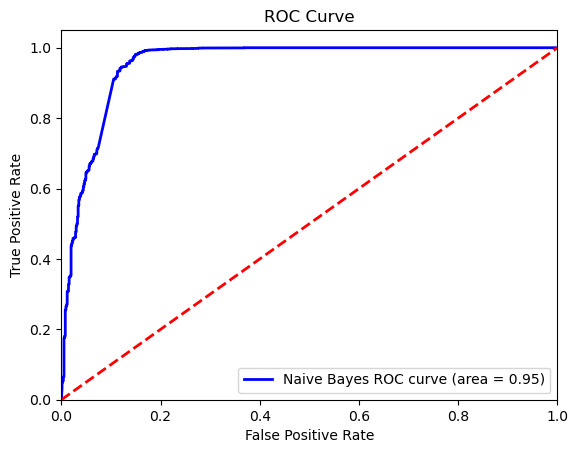

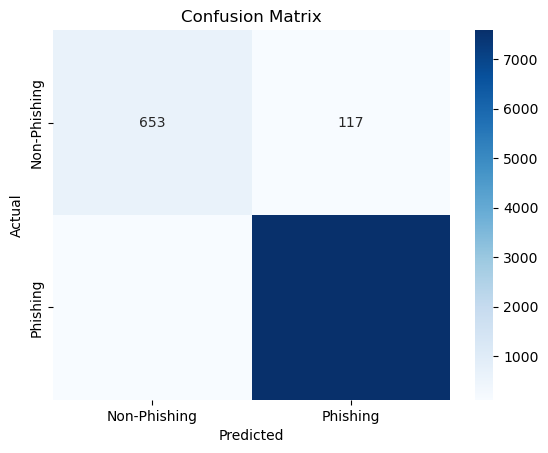

In [8]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/Users/yilu/Downloads/pythonProject/Combined_email.csv'
email_data = pd.read_csv(file_path)

subject_col = 'Subject'
body_col = 'Body'
label_col = 'label'

# Fill missing values with empty strings
email_data[subject_col] = email_data[subject_col].fillna('')
email_data[body_col] = email_data[body_col].fillna('')

# Combine 'Subject' and 'Body' into a single text field for BoW
email_data['text'] = email_data[subject_col] + ' ' + email_data[body_col]

# Function to preprocess text: remove numbers, special characters, and extra spaces/underscores, and very short words
def advanced_preprocess_text_v3(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove very short words (1-2 characters)
    text = re.sub(r'_+', '', text)  # Remove multiple underscores
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

# Apply the advanced preprocessing function to the text column
email_data['cleaned_text_advanced_v3'] = email_data['text'].apply(advanced_preprocess_text_v3)

# Define a custom stop words list including common stop words and additional common email words
custom_stop_words = [
    'subject', 're', 'fw', 'fwd', 'http', 'https', 'www', 'to', 'cc', 'bcc', 'from', 'sent',
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at',
    'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further',
    'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself',
    'let', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'she', 'should', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 'you', 'your', 'yours', 'yourself', 'yourselves',
    # Additional common email words
    'please', 'thank', 'thanks', 'regards', 'best', 'dear', 'kind', 'sincerely', 'hello', 'hi', 'good', 'morning', 'afternoon', 'evening', 'day',
    # Additional non-informative words
    'forwarded', 'original', 'message', 'attached', 'email', 'mail',  'attachment',  'copy', 'paste', 'follow', 'regard', 'response', 'reply','will','enron','know','meeting','new','get','gas','fyi','would','vince','energy','power','need','may','time','monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
    'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
    'jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec','call','today','see','victoria','university'
]

# Define the CountVectorizer with the custom stop words list
bow_vectorizer_custom = CountVectorizer(stop_words=custom_stop_words, max_features=300, min_df=5, max_df=0.7)

# Fit and transform the cleaned text data to obtain BoW features
bow_features_custom = bow_vectorizer_custom.fit_transform(email_data['cleaned_text_advanced_v3'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_features_custom, email_data[label_col], test_size=0.3, random_state=42)

# Train a Naive Bayes model
model = MultinomialNB(alpha=0.6)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Naive Bayes ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('/Users/yilu/Downloads/pythonProject/roc_curve.png')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/Users/yilu/Downloads/pythonProject/confusion_matrix.png')
